# Applying Quadprog to Draw the Efficient Frontier

## Convex Optimization to Draw the Efficient Frontier

Return:

* Given a set of asset returns volatilities and correlations we can plot the efficient frontier.
* We need to have expressions for the return and volatility for a portfolio.

$$R_p = \sum^k_{i=1}w_iR_i$$

> The volatility of the portfolio of assets depends on the correlations but the returns of the portfolio depends only on the returns of the component assets and their weights in the portfolio

Variance:

* The expression for portfolio variance $\sigma^2$ is a generalization of the 2-asset case

$$\sigma^2_p = \sum^k_{i=1}\sum^k_{j=1}w_iw_j\sigma_i\sigma_j\rho_{ij}$$

* In order to find the efficient frontier we use a quadratic optimizer

> The Covariance Matrix is a symmetric matrix with variances along the diagonal and the product of the pairwise correlation and the individual volatililites (i.e. the covariance) on the off-diagonal entries

## Lab Session - Efficient Frontier - Part III - Applying Quadprog to Draw the Efficient Frontier


In order to plot the frontier for portfolios with more than 2 assets, we need to find the weights of the portfolio on the efficient frontier.

We start by creating the same sort of function that we already created for the 2 asset case:

```python

def plot_ef(n_points, er, cov):
    """
    Plots the multi-asset efficient frontier
    """
    # weights = ???? # we need to implement: optimal_weights(n_points, er, cov)
    # we want to minimize volatility given a target return
    # It is going to be a function of returns
    # Otherwise, everything stays the same... well besides the weights.
    # In N-Asset portfolio, finding the weights is the most
    # Challenging part
    weights = optimal_weights(n_points, er, cov)

    
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets, 
        "Volatility": vols
    })
    return ef.plot.line(x="Volatility", y="Returns", style='.-')
```

But let's start by loading up the data as usual:

In [5]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import edhec_risk_kit as erk

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
ind = erk.get_ind_returns()
er = erk.annualize_rets(ind["1996":"2000"], 12)
cov = ind.loc["1996":"2000"].cov()

In order to find the optimal weights, we need a function that will minimize the volatility for a given level of return.


```python
from scipy.optimize import minimize

def minimize_vol(target_return, er, cov):
    """
    Returns the optimal weights that achieve the target return
    given a set of expected returns and a covariance matrix
    """
    # 1. first thing to do is to get the number of assets we have 
    n = er.shape[0]
    """
    The way the  optimizer works: you need to give it an objective function, 
    some constraints, and an initial guess
    """
    # So let's start by the initial guess:
    # Equally weighted gues
    init_guess = np.repeat(1/n, n)
    # For us the bounds are between 0 and 1
    # for n assets
    # Bounds is a touple of touples
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    # I have to make sure that the weights sum to 1:
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    return_is_target = {'type': 'eq', # Type is equality
                        'args': (er,), # additional argument is excpected returns
                        # Functions: stom when targeted return == portfolio return
                        'fun': lambda weights, er: target_return - erk.portfolio_return(weights,er)
    }
    
    # and finally we are able to run the optimizer
    # We want to minimize the volatility 
    # obtained by calling erk.portfolio_vol
    # SLSQP minimizer method is the implementation of the quadratic programming optimizer
    weights = minimize(erk.portfolio_vol, init_guess,
                       args=(cov,), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,return_is_target),
                       bounds=bounds)
    return weights.x
```
Besudes that, everything stays the same... well besides the weights.
So In N-Asset portfolio, finding the weights is the most Challenging part

Let's use this to recreate the result we got from frontier for the 2-Asset optimization between "Games" and "Fin". Let's plot that efficient frontier as we did last time:

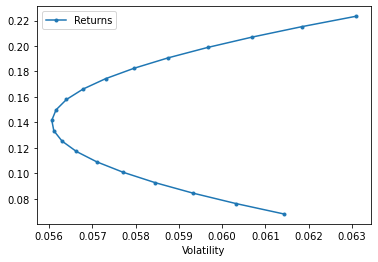

In [13]:
l = ["Games", "Fin"]
erk.plot_ef2(20, er[l], cov.loc[l,l]);

The Efficient Frontier for the portfolio that has a target return of 0.15 is approx 0.056, so let's see if our optimizer is able to locate it.

In [14]:
# Let's see if our function match the plot_ef2 function
# By vol of 15%
weights_15 = erk.minimize_vol(0.15, er[l], cov.loc[l,l])
vol_15 = erk.portfolio_vol(weights_15, cov.loc[l,l])
vol_15

0.056163669406706564

In [16]:
# Vol of 22%
weights_22 = erk.minimize_vol(0.22, er[l], cov.loc[l,l])
vol_22 = erk.portfolio_vol(weights_22, cov.loc[l,l])
vol_22

0.06256928405288453

Now that we can find the weights to minimize the vol given a target return, we can plot the efficient frontier by dividing up the range from the highest to the lowest possible return into a grid, and finding the portfolio that targets the minimum volatility given a particular targeted rate of return

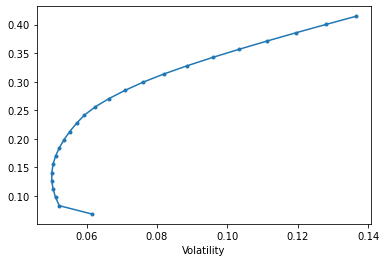

In [11]:
l = ["Smoke", "Fin", "Games", "Coal"]
erk.plot_ef(25, er[l], cov.loc[l,l]);